In [1]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

import pennylane as qml 
from pennylane import qaoa
from pennylane.operation import Operation, AnyWires

In [2]:
def generate_graph(graph,n):
    if graph=='complete':
        G = nx.complete_graph(n)
        E = list(G.edges.data("weight", default=1))
    if graph=='cycle':
        G = nx.cycle_graph(n)
        E = list(G.edges.data("weight", default=1))
    if graph=='turan':
        G = nx.generators.classic.turan_graph(n,n-2)
        E = list(G.edges.data("weight", default=1))
    if graph=='wheel':
        G = nx.wheel_graph(n)
        E = list(G.edges.data("weight", default=1))
    if graph=='3reg':
        d = 3
        G = nx.generators.random_graphs.random_regular_graph(d,n,seed=1)
        E = list(G.edges.data("weight", default=1))

        

    V = np.arange(0,n,1)
    G     = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)

    return n,V,E,G,id
    

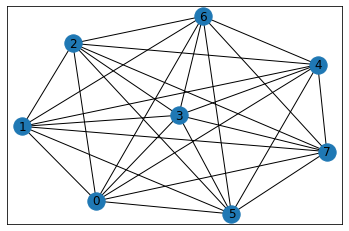

In [3]:
n,V,E,graph,id = generate_graph('complete',8)
nx.draw_networkx(graph)
#plt.savefig("complete8.pdf")

In [4]:
cost_h, mixer_h = qaoa.maxcut(graph)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian (0.5) [Z0 Z1]
+ (0.5) [Z0 Z2]
+ (0.5) [Z0 Z3]
+ (0.5) [Z0 Z4]
+ (0.5) [Z0 Z5]
+ (0.5) [Z0 Z6]
+ (0.5) [Z0 Z7]
+ (0.5) [Z1 Z2]
+ (0.5) [Z1 Z3]
+ (0.5) [Z1 Z4]
+ (0.5) [Z1 Z5]
+ (0.5) [Z1 Z6]
+ (0.5) [Z1 Z7]
+ (0.5) [Z2 Z3]
+ (0.5) [Z2 Z4]
+ (0.5) [Z2 Z5]
+ (0.5) [Z2 Z6]
+ (0.5) [Z2 Z7]
+ (0.5) [Z3 Z4]
+ (0.5) [Z3 Z5]
+ (0.5) [Z3 Z6]
+ (0.5) [Z3 Z7]
+ (0.5) [Z4 Z5]
+ (0.5) [Z4 Z6]
+ (0.5) [Z4 Z7]
+ (0.5) [Z5 Z6]
+ (0.5) [Z5 Z7]
+ (0.5) [Z6 Z7]
+ (-14.0) [I0]
Mixer Hamiltonian (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]
+ (1) [X7]


In [5]:
class QQRA(Operation):

    num_params = 1
    num_wires = AnyWires
    par_domain = "A"

    def __init__(self, weights, wires, ranges=None, imprimitive=None, do_queue=True):

        shape = qml.math.shape(weights)
        self.n_layers = shape[0]


        if shape[1] != len(wires):
            raise ValueError(
                f"Weights tensor must have second dimension of length {len(wires)}; got {shape[1]}"
            )


        if ranges is None:
            if len(wires) > 1:
                # tile ranges with iterations of range(1, n_wires)
                self.ranges = [(l % (len(wires) - 1)) + 1 for l in range(self.n_layers)]
            else:
                self.ranges = [0] * self.n_layers

        self.imprimitive = imprimitive or qml.CNOT

        super().__init__(weights, wires=wires, do_queue=do_queue)

    def expand(self):

        with qml.tape.QuantumTape() as tape:

            for l in range(self.n_layers):

                for i in range(len(self.wires)):
                    qml.RX(self.parameters[0][l, i], wires=self.wires[i])
                    #qml.RY(self.parameters[0][l, i], wires=self.wires[i])
                    #qml.RZ(self.parameters[0][l, i], wires=self.wires[i])
                


        return tape

    @staticmethod
    def shape(n_layers, n_wires):
        r"""Returns the expected shape of the weights tensor.

        Args:
            n_layers (int): number of layers
            n_wires (int): number of wires

        Returns:
            tuple[int]: shape
        """

        return n_layers, n_wires, 3

In [6]:
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        C = C + x[e1]*(1-x[e2]) + x[e2]*(1-x[e1])
        
    return C

In [7]:
wires = range(n)
depth = 1

def circuit(params, **kwargs):
    QQRA(params, wires=list(wires))

dev = qml.device("qulacs.simulator", wires=wires)
cost_function = qml.ExpvalCost(circuit, cost_h, dev)

In [8]:
init_params = qml.init.strong_ent_layers_normal(
    n_wires=n, n_layers=depth
)[:,:,0]

In [9]:
init_params

tensor([[ 0.13225342,  0.0964417 ,  0.16609823,  0.04553103,  0.09260523,
         -0.06717387,  0.02629365,  0.21844364]], requires_grad=True)

In [10]:
opt = qml.GradientDescentOptimizer(stepsize=0.5)
steps = 50

In [11]:
params = init_params
costs = []
for i in range(steps):
    print(i)
    params = opt.step(cost_function, params)
    if (i + 1) % 5 == 0:
        cost_tmp = cost_function(params)
        print("Objective after step {:5d}: {: .7f}".format(i + 1, -cost_tmp))
        costs.append(cost_tmp)

print("Optimal Parameters")
params

0
1
2
3
4
Objective after step     5:  15.0587981
5
6
7
8
9
Objective after step    10:  15.4423052
10
11
12
13
14
Objective after step    15:  15.5640186
15
16
17
18
19
Objective after step    20:  15.8206265
20
21
22
23
24
Objective after step    25:  15.9826166
25
26
27
28
29
Objective after step    30:  15.9989762
30
31
32
33
34
Objective after step    35:  15.9999422
35
36
37
38
39
Objective after step    40:  15.9999967
40
41
42
43
44
Objective after step    45:  15.9999998
45
46
47
48
49
Objective after step    50:  16.0000000
Optimal Parameters


tensor([[ 3.14159031e+00,  3.14144734e+00,  3.14159181e+00,
          2.13962791e-06,  1.41921394e-04, -5.23040266e-06,
          1.00096518e-06,  3.14159245e+00]], requires_grad=True)

In [12]:
dev = qml.device("qulacs.simulator", wires=len(graph.nodes))
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=wires)
probs = probability_circuit(params)

In [13]:
xticks = range(0, 2**n)
xtick_labels = list(map(lambda x: format(x, '0' + str(n) +'b'), xticks))
bitstrings = [format(i, '0' + str(n) +'b') for i in range(len(probs))]

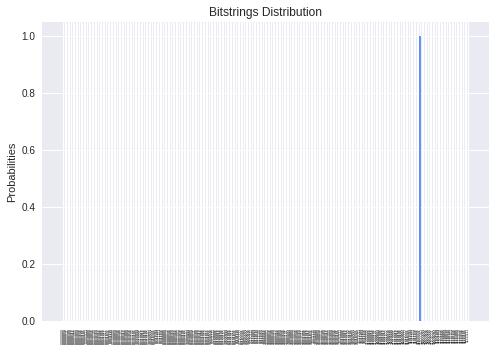

In [28]:
#fig = plt.figure(figsize=(16,14))
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs,tick_label=bitstrings,color="#648FFF")
plt.title("Bitstrings Distribution")
plt.ylabel("Probabilities")
plt.xticks(xticks, xtick_labels, rotation="vertical",size=3.5)
#plt.savefig("distribution.pdf")
plt.show()

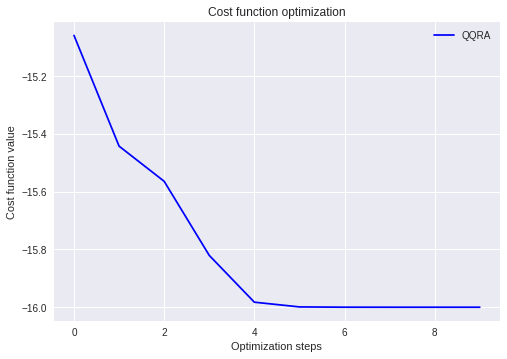

In [25]:
plt.style.use("seaborn")
plt.plot(costs, "b", label="QQRA")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.title("Cost function optimization")
plt.legend()
#plt.savefig("loss.pdf")
plt.show()

In [16]:
avr_C =[]
values = []
hist = {} 


for k in range(len(graph.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for i in range(len(bitstrings)):
    x = [int(digit) for digit in list(bitstrings[i])]
    #x.reverse()
    tmp_eng = cost_function_C(x,graph)
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + probs[i]

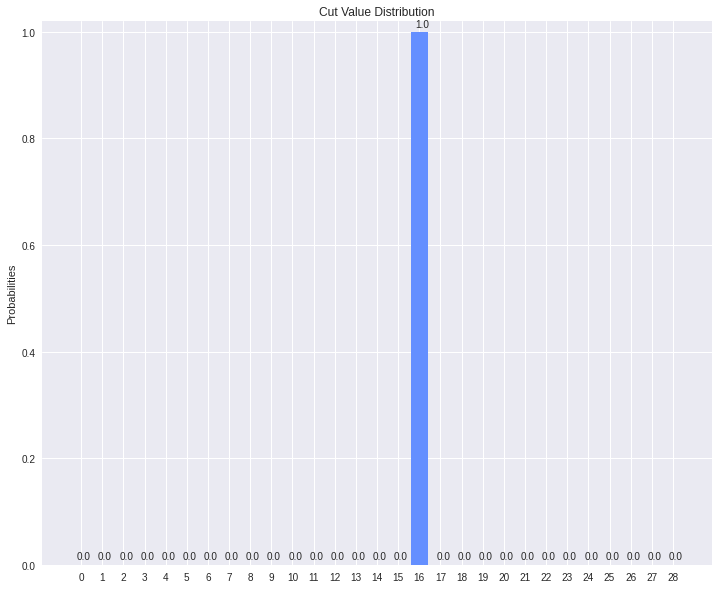

In [23]:
plt.style.use("seaborn")
fig = plt.figure(figsize=(12,10))
plt.bar(range(len(hist)), list(hist.values()), align='center',color="#648FFF")
plt.xticks(range(len(hist)), list(hist.keys()))
plt.title("Cut Value Distribution")
plt.ylabel("Probabilities")
plt.ylim([0,1.02])
xlocs, xlabs = plt.xticks()
hist_values = list(hist.values())
norm_hist_values = [round(float(hist_values[i]),3) for i in range(len(hist_values))]
for i, v in enumerate(norm_hist_values):
    plt.text(xlocs[i] - 0.20, v + 0.01, str(v))
plt.show()
#fig.savefig("result.pdf")